In [444]:
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Import & manipulate historic data

In [445]:
# Use historic data as training set to select important features
# Import the historic data
historic_data = pd.read_csv("../historic_appts_first_pred_trans_ENT.csv")
historic_data

,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,12088942,42,27.45,NaN,0,0,0,4,0,1,...,First prediction,1.0,3,2024-02-14,2,3,10,6,0,3
1,12207851,42,27.45,NaN,1,0,1,4,0,0,...,First prediction,1.0,3,2024-03-12,3,3,10,6,0,4
2,12791383,27,21.70,NaN,0,0,0,3,0,0,...,First prediction,1.0,3,2024-01-31,1,3,10,6,0,2
3,12940266,42,27.45,NaN,1,0,0,2,0,0,...,First prediction,1.0,3,2024-04-03,4,3,10,6,0,1
4,13428133,83,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2024-04-05,4,3,10,6,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5788,20238919,42,21.70,NaN,0,0,0,2,0,1,...,First prediction,1.0,3,2024-04-23,4,111,9,9,0,1
5789,11138651,47,27.45,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2024-02-20,2,3,10,6,0,3
5790,12468296,52,27.45,NaN,0,0,0,1,0,1,...,First prediction,1.0,3,2023-11-25,11,3,10,6,0,3
5791,12799747,72,21.70,NaN,0,0,0,2,0,1,...,First prediction,1.0,3,2023-12-08,12,111,9,6,0,2


In [446]:
# # Keep data related to adult ENT appointments only
# ent_codes = [6, 23,  1,  8, 17, 20, 21, 22,  0, 13, 28, 14, 15,  3, 26, 18, 25, 2, 24, 27, 11,  4, 12, 19,  5, 16,  9,  7, 10]
# historic_data = historic_data[historic_data["reason_display_trans"].isin(ent_codes)]
# historic_data

In [447]:
# Check for missing values
historic_data.isnull().sum()

appointment_id                             0
age_deid                                   0
bmi_deid                                   0
ethnicity                               5793
ethnic_category_black                      0
ethnic_category_unknown                    0
gender_male                                0
imd19_quintile                             0
main_spoken_language_other                 0
current_smoker                             0
substance_misuse                           0
smoking_unknown                            0
tfc_name                                5793
patient_on_multiple_pathways            5793
appt_hour                                  0
appt_duration                              0
new_appt_flag                              0
appointment_type_telephone                 0
appt_hour_11am_to_12pm                     0
appt_hour_12pm_to_1pm                      0
appt_hour_2pm_to_3pm                       0
appt_season_winter                         0
days_last_

In [448]:
# Drop missing & irrelevant columns
historic_data = historic_data.drop(columns=["did_not_attend_risk", # Need to remove this to avoid clustering
                                            "ethnicity", 
                                            "tfc_name",
                                            "patient_on_multiple_pathways",
                                            "weekswaiting",
                                            "prediction_type", 
                                            "use_case", 
                                            "case_control", 
                                            "appt_date",
                                            "days_last_appt"]) 
historic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5793 entries, 0 to 5792
Data columns (total 47 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   appointment_id                        5793 non-null   int64  
 1   age_deid                              5793 non-null   int64  
 2   bmi_deid                              5793 non-null   float64
 3   ethnic_category_black                 5793 non-null   int64  
 4   ethnic_category_unknown               5793 non-null   int64  
 5   gender_male                           5793 non-null   int64  
 6   imd19_quintile                        5793 non-null   int64  
 7   main_spoken_language_other            5793 non-null   int64  
 8   current_smoker                        5793 non-null   int64  
 9   substance_misuse                      5793 non-null   int64  
 10  smoking_unknown                       5793 non-null   int64  
 11  appt_hour        

In [449]:
# Drop missing values
# historic_data = historic_data.dropna()

In [450]:
# Remove all the "_trans" suffixes from the column names

# Identify columns with "_trans" suffix in the test set
columns_to_rename = {col: col.replace('_trans', '') for col in historic_data.columns if col.endswith('_trans')}

# Rename the columns in the test set
historic_data.rename(columns=columns_to_rename, inplace=True)

# List columns in the future_data
historic_data.columns

Index(['appointment_id', 'age_deid', 'bmi_deid', 'ethnic_category_black',
       'ethnic_category_unknown', 'gender_male', 'imd19_quintile',
       'main_spoken_language_other', 'current_smoker', 'substance_misuse',
       'smoking_unknown', 'appt_hour', 'appt_duration', 'new_appt_flag',
       'appointment_type_telephone', 'appt_hour_11am_to_12pm',
       'appt_hour_12pm_to_1pm', 'appt_hour_2pm_to_3pm', 'appt_season_winter',
       'emergency_enc_last_12m_one_or_two',
       'emergency_enc_last_12m_three_or_more', 'lead_time', 'ltc_count',
       'ns_rate_seq', 'num_reschedules_one', 'num_reschedules_two_or_more',
       'op_appts_last_12m', 'osrm_drive_time', 'other_vulnerability',
       'past_no_show_count_one', 'past_no_show_count_three_or_more',
       'past_no_show_count_two', 'past_no_show_rate', 'phone_number',
       'physically_inactive', 'safeguarding',
       'service_mapping_allied_hcp_therapy', 'service_mapping_paeds',
       'service_mapping_priority', 'service_mapping_

### Import & manipulate future data

In [451]:
# # Import the transformed use case 1 data (future data) as test set
# future_data = pd.read_csv("../future_appts_trans.csv")
# future_data

In [452]:
# # Keep data related to adult ENT appointments only
# ent_codes = [1,  2,  7,  8,  0,  6,  4, 10,  9,  5,  3, 11, 12]
# future_data = future_data[future_data["reason_display_trans"].isin(ent_codes)]
# future_data

In [453]:
# # Import the transformed ENT future data as test set
future_data = pd.read_csv("../future_appts_trans_ENT.csv")

In [454]:
# Check for missing values
future_data.isnull().sum()

appointment_id                             0
age_deid                                   0
bmi_deid                                   0
ethnic_category_black                      0
ethnic_category_unknown                    0
gender_male                                0
imd19_quintile                             0
main_spoken_language_other                 0
current_smoker                             0
substance_misuse                           0
smoking_unknown                            0
appt_hour                                  0
appt_duration                              0
reason_display                             0
appointment_type                           0
new_appt_flag                              0
appointment_type_telephone                 0
appt_hour_11am_to_12pm                     0
appt_hour_12pm_to_1pm                      0
appt_hour_2pm_to_3pm                       0
appt_season_winter                         0
days_last_appt                             0
emergency_

In [455]:
# Drop missing & irrelevant columns
future_data = future_data.drop(columns=["no_show", 
                                        "prediction_type", 
                                        "case_control", 
                                        "use_case",
                                        "appt_date",
                                        "days_last_appt",
                                        "reason_display", # Untransformed column - need to remove this to align with the training set
                                        "appointment_type"]) # Untransformed column - need to remove this to align with the training set

future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 51 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   appointment_id                        2560 non-null   int64  
 1   age_deid                              2560 non-null   int64  
 2   bmi_deid                              2560 non-null   float64
 3   ethnic_category_black                 2560 non-null   int64  
 4   ethnic_category_unknown               2560 non-null   int64  
 5   gender_male                           2560 non-null   int64  
 6   imd19_quintile                        2560 non-null   int64  
 7   main_spoken_language_other            2560 non-null   int64  
 8   current_smoker                        2560 non-null   int64  
 9   substance_misuse                      2560 non-null   int64  
 10  smoking_unknown                       2560 non-null   int64  
 11  appt_hour        

In [456]:
# Remove all the "_trans" suffixes from the column names

# Identify columns with "_trans" suffix in the test set
columns_to_rename = {col: col.replace('_trans', '') for col in future_data.columns if col.endswith('_trans')}

# Rename the columns in the test set
future_data.rename(columns=columns_to_rename, inplace=True)

# List columns in the future_data
future_data.columns

Index(['appointment_id', 'age_deid', 'bmi_deid', 'ethnic_category_black',
       'ethnic_category_unknown', 'gender_male', 'imd19_quintile',
       'main_spoken_language_other', 'current_smoker', 'substance_misuse',
       'smoking_unknown', 'appt_hour', 'appt_duration', 'new_appt_flag',
       'appointment_type_telephone', 'appt_hour_11am_to_12pm',
       'appt_hour_12pm_to_1pm', 'appt_hour_2pm_to_3pm', 'appt_season_winter',
       'emergency_enc_last_12m_one_or_two',
       'emergency_enc_last_12m_three_or_more', 'lead_time', 'ltc_count',
       'ns_rate_seq', 'num_reschedules_one', 'num_reschedules_two_or_more',
       'op_appts_last_12m', 'osrm_drive_time', 'other_vulnerability',
       'past_no_show_count_one', 'past_no_show_count_three_or_more',
       'past_no_show_count_two', 'past_no_show_rate', 'phone_number',
       'physically_inactive', 'safeguarding',
       'service_mapping_allied_hcp_therapy', 'service_mapping_paeds',
       'service_mapping_priority', 'service_mapping_

In [457]:
# # Transform risk categories so that 1 = very high risk and 0 = the rest (high, moderate, low)
# future_data["did_not_attend_risk_group"] = future_data["did_not_attend_risk_group"].apply(lambda x: 1 if x == 4 else 0)

# # Check the transformation has been properly applied
# future_data["did_not_attend_risk_group"].unique()

### Exploratory analysis: compare means (historic data)

In [458]:
historic_data.info()
# Continuous variables: age_deid, bmi_deid, lead_time, ltc_count, ns_rate_seq, op_appts_last_12m, osrm_drive_time, did_not_attend_risk

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5793 entries, 0 to 5792
Data columns (total 47 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   appointment_id                        5793 non-null   int64  
 1   age_deid                              5793 non-null   int64  
 2   bmi_deid                              5793 non-null   float64
 3   ethnic_category_black                 5793 non-null   int64  
 4   ethnic_category_unknown               5793 non-null   int64  
 5   gender_male                           5793 non-null   int64  
 6   imd19_quintile                        5793 non-null   int64  
 7   main_spoken_language_other            5793 non-null   int64  
 8   current_smoker                        5793 non-null   int64  
 9   substance_misuse                      5793 non-null   int64  
 10  smoking_unknown                       5793 non-null   int64  
 11  appt_hour        

In [459]:
# Create the an exploratory df by extracting the continuous variables and the target variable
continuous_vars = ["age_deid", "bmi_deid", "lead_time", "ltc_count", "ns_rate_seq", "op_appts_last_12m", "osrm_drive_time"]
exploratory_data = historic_data[continuous_vars + [ "did_not_attend_risk_group"]]
exploratory_data

,age_deid,bmi_deid,lead_time,ltc_count,ns_rate_seq,op_appts_last_12m,osrm_drive_time,did_not_attend_risk_group
0,42,27.45,232,5,0.05,8,7.00,3
1,42,27.45,308,0,0.33,0,7.00,4
2,27,21.70,225,1,0.05,2,7.00,2
3,42,27.45,48,0,0.05,0,7.00,1
4,83,21.70,252,5,0.05,6,7.10,3
...,...,...,...,...,...,...,...,...
5788,42,21.70,4,0,0.05,5,8.71,1
5789,47,27.45,308,0,0.05,3,7.00,3
5790,52,27.45,144,0,0.13,0,8.59,3
5791,72,21.70,219,2,0.09,0,6.52,2


In [460]:
# Perform independent two-sample t-test for the exploratory data

# Initialise a list to sore results
results = []

# Loop through the continuous variables
for var in continuous_vars:
    # Split out the 2 risk groups
    risk_veryHigh = exploratory_data[exploratory_data["did_not_attend_risk_group"] == 4]
    risk_lower = exploratory_data[exploratory_data["did_not_attend_risk_group"] != 4]

    # Calculate the t-statistic and p-value
    t_stat, p_value = ttest_ind(risk_veryHigh[var], risk_lower[var])

    # Calculate the mean
    mean_veryHigh = risk_veryHigh.mean()
    mean_lower = risk_lower.mean()

    # Store the results
    results.append({
        "Variables": var,
        "Mean very high risk": mean_veryHigh[var],
        "Mean lower risk": mean_lower[var],
        "t-statistic": t_stat,
        "p-value": p_value
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df



,Variables,Mean very high risk,Mean lower risk,t-statistic,p-value
0,age_deid,36.028986,45.902210,-5.464730,4.829710e-08
1,bmi_deid,28.278623,28.431202,-0.273422,7.845383e-01
2,lead_time,200.086957,99.986561,10.860380,3.251872e-27
3,ltc_count,0.949275,1.233775,-1.941374,5.226136e-02
4,ns_rate_seq,0.322029,0.085240,49.168210,0.000000e+00
5,op_appts_last_12m,2.014493,3.147303,-3.528613,4.209863e-04
6,osrm_drive_time,7.673623,7.865195,-0.604353,5.456327e-01


### Select subset of important features using GenericUnivariateSelect

#### V1: outcome = did not attend risk; drop: no show (historic)

In [461]:
# Define training and test sets
X_train = historic_data.drop(["did_not_attend_risk_group", "no_show"], axis=1)
y_train = historic_data["did_not_attend_risk_group"]

X_test = future_data.drop("did_not_attend_risk_group", axis=1)
y_test = future_data["did_not_attend_risk_group"]

#### V2: outcome = no show; drop: did not attend risk (historic) 
##### --> no distinctive differences shown on t-SNE, so using V1

In [462]:
# # Define training and test sets
# X_train = historic_data.drop(["did_not_attend_risk_group", "no_show"], axis=1)
# y_train = historic_data["no_show"]

# X_test = future_data.drop("did_not_attend_risk_group", axis=1)
# y_test = future_data["did_not_attend_risk_group"]

In [463]:
# Identify missing features - fix with new data
missing_in_train = set(X_test.columns) - set(X_train.columns)
missing_in_test = set(X_train.columns) - set(X_test.columns)

print("Features in test set but not in training set:", missing_in_train)
print("Features in training set but not in test set:", missing_in_test)

Features in test set but not in training set: {'weekswaiting', 'patient_on_multiple_pathways', 'did_not_attend_risk', 'ethnicity', 'tfc_name'}
Features in training set but not in test set: set()


In [464]:
# Align feature columns by deleting columns from testing (future appts) set
X_test = X_test.drop(columns=['weekswaiting', 'patient_on_multiple_pathways', 'did_not_attend_risk', 'ethnicity', 'tfc_name'])

# # Add missing columns to training set with default values (e.g., 0)
# for col in missing_in_train:
#     X_train[col] = 0

# # Add missing columns to test set with default values (e.g., 0)
# for col in missing_in_test:
#     X_test[col] = 0

# # Reorder the columns to match
# X_train = X_train[sorted(X_train.columns)]
# X_test = X_test[sorted(X_test.columns)]




In [465]:
print("Columns in X_train:\n", X_train.columns)
print("Columns in X_test:\n", X_test.columns)

Columns in X_train:
 Index(['appointment_id', 'age_deid', 'bmi_deid', 'ethnic_category_black',
       'ethnic_category_unknown', 'gender_male', 'imd19_quintile',
       'main_spoken_language_other', 'current_smoker', 'substance_misuse',
       'smoking_unknown', 'appt_hour', 'appt_duration', 'new_appt_flag',
       'appointment_type_telephone', 'appt_hour_11am_to_12pm',
       'appt_hour_12pm_to_1pm', 'appt_hour_2pm_to_3pm', 'appt_season_winter',
       'emergency_enc_last_12m_one_or_two',
       'emergency_enc_last_12m_three_or_more', 'lead_time', 'ltc_count',
       'ns_rate_seq', 'num_reschedules_one', 'num_reschedules_two_or_more',
       'op_appts_last_12m', 'osrm_drive_time', 'other_vulnerability',
       'past_no_show_count_one', 'past_no_show_count_three_or_more',
       'past_no_show_count_two', 'past_no_show_rate', 'phone_number',
       'physically_inactive', 'safeguarding',
       'service_mapping_allied_hcp_therapy', 'service_mapping_paeds',
       'service_mapping_priorit

In [466]:
# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [467]:
# Fit GenericUnivariateSelect with mutual information for feature selection
selector = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=20) # Select top 20% of features
X_train_selected = selector.fit_transform(X_train_scaled, y_train) # Fit the selector to the training data

# Identify selected features
selected_features = selector.get_support(indices=True) # Returns an array of indices of selected features
selected_features_names = X_train.columns[selected_features] # Get the names of selected features
selected_features_names

Index(['appointment_id', 'age_deid', 'appt_duration', 'lead_time',
       'ns_rate_seq', 'osrm_drive_time', 'past_no_show_count_three_or_more',
       'past_no_show_rate', 'reason_display'],
      dtype='object')

### Fit & plot t-SNE

In [468]:
# Transform the test set for consistency & reduce dimensionality
X_test_selected = selector.transform(X_test_scaled)

In [469]:
# # Transform risk categories so that 1 = very high risk and 0 = the rest (high, moderate, low)
# historic_data["did_not_attend_risk_group"] = historic_data["did_not_attend_risk_group"].apply(lambda x: 1 if x == "Very High Risk" else 0)

# # Check the transformation has been properly applied
# historic_data["did_not_attend_risk_group"].unique()

In [470]:
# Apply t-SNE on the selected features of the test set
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test_selected) # Fit and transform the data

In [471]:
# Create a DataFrame with the t-SNE data
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["did_not_attend_risk_group"] = y_test.reset_index(drop=True) # Add the target variable

In [472]:
# # Plot the t-SNE (for 2 risk categories: very high risk vs the rest)
# colours = {0: "blue", 1: "red"}

# plt.figure(figsize=(10, 8))
# for category in tsne_df['did_not_attend_risk_group'].unique():
#     subset = tsne_df[tsne_df['did_not_attend_risk_group'] == category]
#     plt.scatter(subset['TSNE1'], subset['TSNE2'], label=category, color=colours[category], alpha=0.6, edgecolors='w', s=100)

# # Add title and labels
# plt.title('t-SNE Visualization of Patient Data (Selected Features with Mutual Information)')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')

# # Add legend
# plt.legend(title='Risk Category')

# # Show plot
# plt.show()

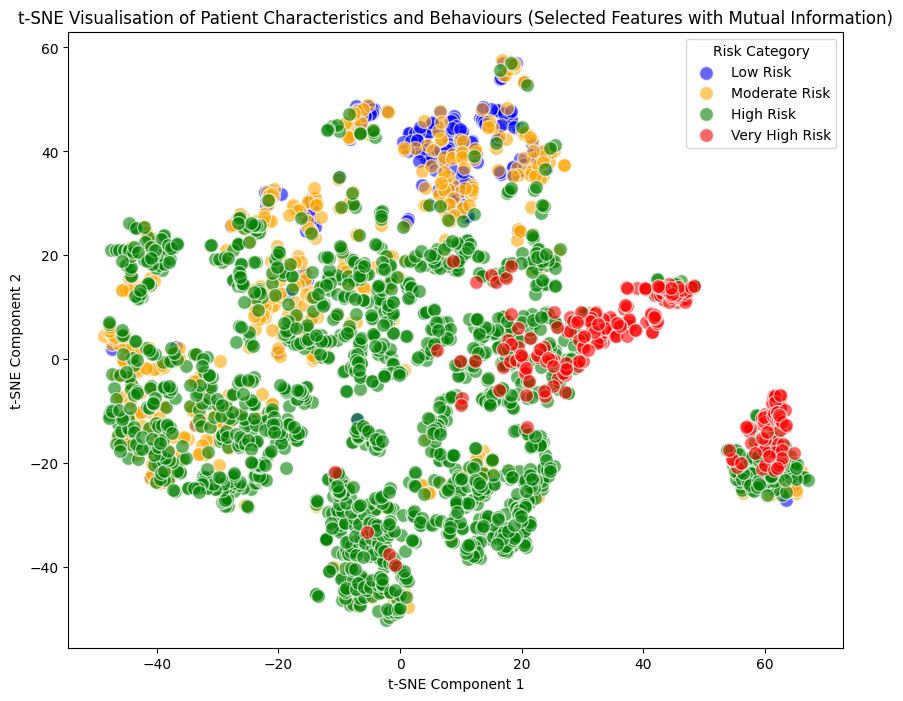

In [500]:
import matplotlib.pyplot as plt

# Map numerical categories to descriptive names
category_names = {
    1: "Low Risk",
    2: "Moderate Risk",
    3: "High Risk",
    4: "Very High Risk"
}

colours = {
    1: "blue",
    2: "orange",
    3: "green",
    4: "red"
}

plt.figure(figsize=(10, 8))

# Collect handles and labels
handles = []
labels = []

for category in sorted(tsne_df['did_not_attend_risk_group'].unique()):
    subset = tsne_df[tsne_df['did_not_attend_risk_group'] == category]
    scatter = plt.scatter(subset['TSNE1'], subset['TSNE2'], 
                          label=category_names[category], 
                          color=colours[category], alpha=0.6, 
                          edgecolors='w', s=100)
    handles.append(scatter)
    labels.append(category_names[category])

# Order the categories in the desired order: 1 (Low Risk), 2 (Moderate Risk), 3 (High Risk), 4 (Very High Risk)
sorted_indices = [0, 1, 2, 3]  # Correct order for the legend

# Reorder the handles and labels based on the sorted indices
handles = [handles[i] for i in sorted_indices]
labels = [labels[i] for i in sorted_indices]

# Add title and labels
plt.title('t-SNE Visualisation of Patient Characteristics and Behaviours (Selected Features with Mutual Information)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add legend with sorted handles and labels
plt.legend(handles=handles, labels=labels, title='Risk Category')

# Show plot
plt.show()


# Draw out the differences by comparing the selected features

In [474]:
# Create a dataframe with the selected features
selected_data = future_data[selected_features_names]

# Add the risk group column
selected_data["did_not_attend_risk_group"] = y_test.reset_index(drop=True) 

/var/folders/0t/dc47jt692_qc1qb7bqkgylhw0000gn/T/ipykernel_34663/3671777271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["did_not_attend_risk_group"] = y_test.reset_index(drop=True)


In [475]:
# Group by risk category and summarise: continuous variables
grouped_data_cont = selected_data.drop(["appointment_id", "appt_duration", "reason_display"], axis=1).groupby("did_not_attend_risk_group").agg(["mean", "std"])
grouped_data_cont

age_deid              lead_time             \
                                mean        std        mean        std   
did_not_attend_risk_group                                                
1                          57.049751  18.681475  128.169154  80.332318   
2                          56.992945  18.801829  270.631393  97.236497   
3                          44.760491  18.214061  328.863138  58.276999   
4                          38.197531  15.731807  330.757202  56.178607   

                          ns_rate_seq           osrm_drive_time            \
                                 mean       std            mean       std   
did_not_attend_risk_group                                                   
1                            0.060498  0.017428        7.760995  3.477802   
2                            0.065608  0.023044        7.364444  3.467382   
3                            0.094932  0.045059        7.968367  3.655043   
4                            0.271770  0.104927        8.630658  4.360305   

                          past_no_show_count_three_or_more            \
                                                      mean       std   
did_not_attend_risk_group                                              
1                                                 0.019900  0.140007   
2                                                 0.022928  0.149805   
3                                                 0.052937  0.223981   
4                                                 0.296296  0.457566   

                          past_no_show_rate            
                                       mean       std  
did_not_attend_risk_group                              
1                                  0.018955  0.048687  
2                                  0.033086  0.069135  
3                                  0.088509  0.147797  
4                                  0.542716  0.304749

In [476]:
# Group by risk category and summarise: categorical variables
print(selected_data[["reason_display"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())
print()
print(selected_data[["age_deid"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())
print()
print(selected_data[["appt_duration"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

reason_display                   0         1         2         3         4   \
did_not_attend_risk_group                                                     
1                          0.009950  0.353234  0.383085  0.019900  0.004975   
2                          0.005291  0.167549  0.760141       NaN       NaN   
3                          0.005165  0.049064  0.936088  0.001937       NaN   
4                               NaN  0.020576  0.979424       NaN       NaN   

reason_display                   5         6         7         8         9   \
did_not_attend_risk_group                                                     
1                          0.004975  0.144279       NaN  0.014925  0.004975   
2                          0.001764  0.028219  0.005291  0.012346  0.005291   
3                               NaN  0.003228       NaN  0.001291       NaN   
4                               NaN       NaN       NaN       NaN       NaN   

reason_display                   10        11     

#### Adding in features selected by the client

In [477]:
# Ethnicity: black
print(historic_data[["ethnic_category_black"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

ethnic_category_black             0         1
did_not_attend_risk_group                    
1                          0.837029  0.162971
2                          0.786380  0.213620
3                          0.760357  0.239643
4                          0.746377  0.253623


In [478]:
# Other vulnerability
print(historic_data[["other_vulnerability"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

other_vulnerability               0         1
did_not_attend_risk_group                    
1                          0.986696  0.013304
2                          0.979627  0.020373
3                          0.969131  0.030869
4                          0.949275  0.050725


In [479]:
# IMD 19 quitile
print(historic_data[["imd19_quintile"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

imd19_quintile                    1         2         3         4         5
did_not_attend_risk_group                                                  
1                          0.207687  0.429786  0.246859  0.100517  0.015152
2                          0.266007  0.452852  0.208382  0.068102  0.004657
3                          0.310317  0.450041  0.184403  0.051990  0.003249
4                          0.355072  0.391304  0.188406  0.057971  0.007246


In [480]:
# Safeguarding
print(historic_data[["safeguarding"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

safeguarding                      0         1
did_not_attend_risk_group                    
1                          0.980414  0.019586
2                          0.946449  0.053551
3                          0.922015  0.077985
4                          0.905797  0.094203


In [481]:
# Substance misuse
print(historic_data[["substance_misuse"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

substance_misuse                  0         1
did_not_attend_risk_group                    
1                          0.994457  0.005543
2                          0.986030  0.013970
3                          0.959383  0.040617
4                          0.949275  0.050725
